# Lab 4 Image processing

Images are mathematically modeled as functions of two variables. These variables represent the vertical coordinate $m$ and the horizontal coordinate $n$. These variables can be discrete or continuous but we will consider them here to be discrete. In this case the coordinate pair $(m, n)$ is called a pixel. We restrict each pixel coordinate to be between 0 and $N-1$. We use $\mathbf{X}$ to denote the image and and $x(m, n)$ to represent the value at pixel $(m, n)$. Pixels of an image are arranged in a matrix,
$$
\mathbf{X}=\left(\begin{array}{cccccc}
x(0,0) & x(0,1) & \cdots & x(0, n) & \cdots & x(0, N) \\
x(1,0) & x(1,1) & \cdots & x(1, n) & \cdots & x(1, N) \\
\vdots & \vdots & & \vdots & & \vdots \\
x(m, 0) & x(m, 1) & \cdots & x(m, n) & \cdots & x(m, N) \\
\vdots & \vdots & & \vdots & & \vdots \\
x(N, 0) & x(N, 1) & \cdots & x(N, n) & \cdots & x(N, N)
\end{array}\right)
$$
Thus, an image $\mathbf{X}$ is a matrix in which entries $x(m, n)$ represent pixel values.

The interpretation of this matrix is that pixel values $x(m, n)$ represent the luminance of the pixel. The luminance is how much light is reflected by the pixel.

## Handwritten Digits

In this lab we work with black and white images that represent handwritten digits. In Figure 1 we show an image of a handwritten number 1 and a handwritten number 3 . The dataset we are given contains pairs $\left(\mathbf{X}_q, y_q\right)$ of images $\mathbf{X}_q$ and human annotations $y_q$ that identify the correct digits.

## Task 1:
Load the data and visualize three images.

### Setup

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time

### Loading the Data

We will use torchvision's MNIST dataset class to download the data.

In [2]:
# Image normalization
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

# Download MNIST train and test set and normalize images
train_set = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Define train and test dataloaders, used to get batches sequentially
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128)
test_loader = torch.utils.data.DataLoader(train_set, batch_size=1024)

100%|████████████████████████████| 9912422/9912422 [00:02<00:00, 3889716.68it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|████████████████████████████████| 28881/28881 [00:00<00:00, 3981976.06it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|████████████████████████████| 1648877/1648877 [00:01<00:00, 1230558.51it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 3852483.07it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Visualize Images

Image size torch.Size([28, 28]) 



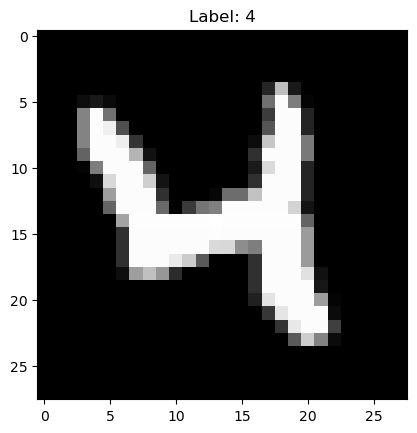

In [3]:
# Sample Visualization
img_index = 20
image = train_set[img_index][0].squeeze()
plt.imshow(image, cmap = 'binary_r')
plt.title(f"Label: {train_set[img_index][1]}")
print(f"Image size {image.shape} \n")

## Shifts in Space
Before defining convolutions to process images we have to introduce vertical and horizontal shift operators. We name these operators $\mathcal{S}_{\mathrm{v}}$ and $\mathcal{S}_{\mathrm{H}}$ and define them as the operators whose action on an image $\mathbf{X}$ results in a shifting of vertical and horizontal coordinates, respectively. Thus, if applying the vertical shift $\mathcal{S}_{\mathrm{v}}$ to the image $\mathbf{X}$ yields the image $\mathbf{U}_{10}=\mathcal{S}_{\mathrm{v}} \mathbf{X}$, the entries $u_{10}(m, n)$ of the vertically shifted image $\mathbf{U}_{10}$ are
$$
u_{10}(m, n)=x(m-1, n), \text { when } \mathbf{U}_{10}=\mathcal{S}_{\mathrm{v}} \mathbf{X}
$$
Likewise if applying the vertical shift $\mathcal{S}_{\mathrm{H}}$ to the image $\mathbf{X}$ yields the image $\mathbf{U}_{01}=\mathcal{S}_{\mathrm{v}} \mathbf{X}$, the entries $u_{01}(m, n)$ of the horizontally shifted image $\mathbf{U}_{01}$ are
$$
u_{01}(m, n)=x(m, n-1), \quad \text { when } \mathbf{U}_{01}=\mathcal{S}_{\mathrm{H}} \mathbf{X}
$$

### Shift Compositions and Spatial Shift Sequences

As in the case of time signals, image shifts can be composed. We can compose any number of vertical shifts with any number of horizontal shifts. This results in the definition of the spatial shift sequence composed of images
$$
\mathbf{U}_{k l}=\mathcal{S}_{\mathrm{v}}^k \mathcal{S}_{\mathrm{H}}^l \mathbf{X} .
$$

This is an image in which the entries are $u_{k l}(m, n)=x(m-k, n-l)$. That is, the image $\mathbf{U}_{k l}$ is one in which the pixels are shifted $k$ pixels down and $l$ pixels to the right.

It is important to note that the spatial shift sequence in (10) can be computed recursively. To do that we need to define the vertical and horizontal recursions
$$
\mathbf{U}_{k l}=\mathcal{S}_{\mathrm{v}} \mathbf{U}_{(k-1) l}, \quad \mathbf{U}_{k l}=\mathcal{S}_{\mathrm{H}} \mathbf{U}_{k(l-1)},
$$
with the initial condition $\mathbf{U}_{00}=\mathbf{X}$. Recursive computation of the spatial diffusion sequence is important in practical implementations.

### Negative shifts

A negative vertical shift is a shift that moves the pixels up. We denote this shift by $\mathcal{S}_{\mathrm{v}}^{-1}$ and define it as the shift that when acting on the image $\mathbf{X}$ yields the image $\mathbf{U}_{(-1) 0}=\mathcal{S}_v^{-1} \mathbf{X}$ whose entries are given by
$$
u_{(-1) 0}(m, n)=x(m+1, n), \quad \text { when } \mathbf{U}_{(-1) 0}=\mathcal{S}_{\mathrm{v}}^{-1} \mathbf{X} .
$$
In this definition we adopt the convention that $x(N+1, n)=0$. This means that when applying the negative shift $\mathcal{S}_{\mathrm{v}}^{-1}$ we fill the last row of $\mathbf{U}_{(-1) 0}$ with zeros. This is because there are no entries of $\mathbf{X}$ that can be shifted into this row.

Likewise a negative horizontal shift is a shift that moves the pixels left. We denote this shift by $\mathcal{S}_{\mathrm{H}}^{-1}$ and define it as the shift that when acting on the image $\mathbf{X}$ yields the image $\mathbf{U}_{0(-1)}=\mathcal{S}_{\mathrm{H}}^{-1} \mathbf{X}$ whose entries are given by
$$
u_{0(-1)}(m, n)=x(m, n+1) \text {, when } \mathbf{U}_{0(-1) 0}=\mathcal{S}_{\mathrm{H}}^{-1} \mathbf{X} .
$$
In this definition we adopt the convention that $x(m, N+1)=0$. This means that when applying the negative shift $\mathcal{S}_{\mathrm{H}}^{-1}$ we fill the last column of $\mathbf{U}_{(-1) 0}$ with zeros. This is because there are no entries of $\mathbf{X}$ that can be shifted into this column.

As is the case of the positive shifts $\mathcal{S}_{\mathrm{v}}$ and $\mathcal{S}_{\mathrm{H}}$, the negative shifts $\mathcal{S}_{\mathrm{V}}^{-1}$ and $\mathcal{S}_{\mathrm{H}}^{-1}$ can be composed.


## Convolutions in space

A spatial convolution is a linear combination of the components of the spatial diffusion sequence in (14). For a formal definition we consider a filter range $K$ and define filter coefficients $h_{k l}$ for $k$ and $l$ ranging from $-K$ to $K$. The outcome of applying the filter with coefficients $h_{k l}$ to the image $\mathbf{X}$ is the image
$$
\mathbf{Y}=\sum_{k=-K}^K \sum_{l=-K}^K h_{k l} \mathcal{S}_{\mathrm{v}}^k \mathcal{S}_{\mathrm{H}}^l \mathbf{X} .
$$
Observe that in this definition we allow for positive and negative shifts. For simplicity we assume that the maximum number of shifts in either direction is the same. They can be made different, but it is standard practice to keep them equal.

We note that the total number of filter coefficients of a two dimensional convolution is $(2 K+1)^2$. These coefficients are arranged in a matrix $\mathbf{H}$.

## Task 2A

 Write a function that takes an image $\mathbf{X}$ and a filter  $\mathbf{H}$ as an input and returns as an output the result of convolving the mage with the filter.


In [4]:
def conv2D(image, filters):
    """
    Performs 2D convolution on the given image with the given filters.
    Args:
        image (torch.Tensor): input image of shape (height, width).
        filters (torch.Tensor): filters of shape (num_filters, filter_size, filter_size).
                            where filter_size is 2*K+1

    Returns:
        torch.Tensor: convolved image of shape (num_kernels, height, width).
    """

    num_filters, m, n = filters.shape
    y, x = image.shape

    y_pad = y + m - 1
    x_pad = x + n - 1

    # Initialize output tensor
    result = torch.zeros((num_filters, y_pad, x_pad))
    result[:, m//2:y_pad-m//2, n//2:x_pad-n//2] = image

    # Initialize output
    output = torch.zeros((num_filters, y, x))
    # Iterate over the kernels
    for idx in range(num_filters):
        filter = filters[idx]
        # Iterate over the kernel entries
        for i in range(m):
            for j in range(n):
                # Shift the image vertically and then horizontally
                rolled_image = torch.roll(torch.roll(result[idx], -i+m//2, dims=0), -j+n//2, dims=1)
                # Multiply the kernel with the rolled image and sum the result
                output[idx] += rolled_image[m//2: m//2+y, n//2: n//2+x] * filter[i, j]

    return output

## Task 2B

Define a FilterBank class that inherits from nn.module. It stores filter parameters as an attribute and its forward method will compute the convolution of a batch of input images.

In [6]:
class FilterBank(nn.Module):
    def __init__(self,  num_filters, K):
        super(FilterBank, self).__init__()

        L = K*2+1
        self.num_filters = num_filters
        self.filters = torch.zeros((num_filters, L, L))

    def forward(self, x):

        b, h, w = x.shape
        out = torch.zeros((b, self.num_filters, h, w))

        # Iterate over images in the batches
        for i, img in enumerate(x):
            out[i] = conv2D(img, self.filters)

        return out

## Task 3
Define filters H with entries $h_{kl} = 1/(2K + 1)^2$ Use the class inTask 2 to instantiate these filters with K = 2, K = 4, and K = 8. Apply these filters to the images you visualized in Task 1. 

What is the effect of applying these filters?

Text(0.5, 1.0, 'Original image')

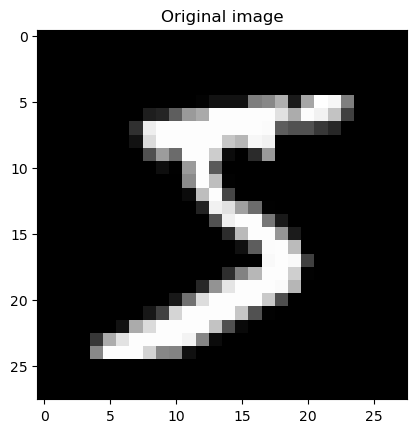

In [7]:
img = train_set[0][0]
plt.imshow(img.squeeze(), cmap = 'binary_r')
plt.title("Original image")

Text(0.5, 1.0, 'Covolved image with K=2')

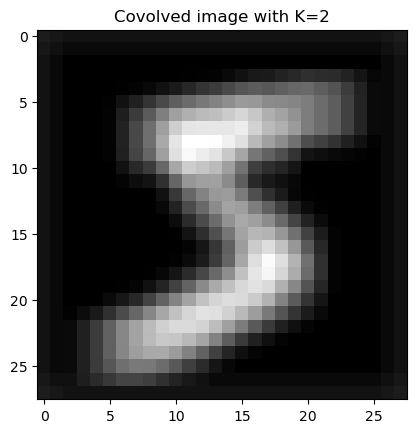

In [10]:
K = 2
# Instatiate FIlter Bank with one Filter
filt = FilterBank(num_filters = 1, K = K)
# Set to  uniform filter
filt.filters = torch.ones((1, 2*K+1, 2*K+1))*(1/(2*K+1)**2)
# Perform 2D convolution
out = filt(img)

plt.imshow(out.squeeze(), cmap = 'binary_r')
plt.title("Covolved image with K=2")

Text(0.5, 1.0, 'Covolved image with K=4')

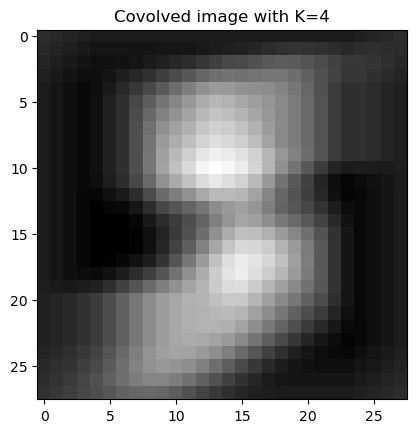

In [11]:
K = 4
# Instatiate FIlter Bank with one Filter
filt = FilterBank(num_filters = 1, K = 4)
# Set to  uniform filter
filt.filters = torch.ones((1, 2*K+1, 2*K+1))*(1/(2*K+1)**2)
# Perform 2D convolution
out = filt(img)

plt.imshow(out.squeeze(), cmap = 'binary_r')
plt.title("Covolved image with K=4")

## Task 4

Pytorch comes with its own function for computing two dimensional convolutions. Consider the same filters of Task 3 with K = 8. Execute your own convolution code and the code that comes built in Pytorch to compute convolutions for a batch of B = 100 images. Compare the execution times.

In [22]:
# Grab batch of 100 images from the dataset
imgs = next(iter(train_loader))[0][:100]

# Perform convolution with function from torch
K = 8
conv = nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = 2*K+1, padding = 'same', bias = False)
# Time convolution
start = time.time()
out = conv(imgs)
end = time.time()

print(f"PyTorch's Convolution took: {end-start:.3f} seconds")

# Perform convolution with your function
filterbank = FilterBank(num_filters = 1, K = 8)
# Initialize filters with the torch initialization
filterbank.filters = conv.weight.squeeze(0)

start = time.time()
out_manual = filterbank(imgs.squeeze())
end = time.time()
print(f"Manual Convolution took: {end-start:.3f} seconds")


# Check that outputs match
print(f"Manual convolution and torch convolution output the same tensor: {torch.allclose(out_manual, out, atol = 1e-5)}")

PyTorch's Convolution took: 0.007 seconds
Manual Convolution took: 0.562 seconds
Manual convolution and torch convolution output the same tensor: True


In solving Task 4 you must have noticed that the Pytorch code is much faster. This is because the Pytorch convolution function is just a wrapper that calls a compiled subroutine written in C. If this were the 1990’s we would say that “true men code in C,” which was indeed a quip that was common in the 1990’s. Lucky for us all we live in a time when we do not require men to be tough, nor women to stay away from engineering, nor persons to define themselves as either men or women. So let us just remember that industry level data sciences still relies on low level languages. Python and Pytorch are prototyping languages. We will use the Pytorch convolution function in the remainder of Lab 4.

## Task 5 

Create a filterbank class. In this class the filter coefficients $H_g$ the matrix A are attributes. The class has a method that takes an image X as an input and implements the filterbank equations in (17) - (19). The method returns the vector of scores x2 as an output.

In [23]:
class FilterBank(nn.Module):
    def __init__(self, num_filters, K):
        super(Classifier, self).__init__()

        # In the MNIST dataset each class corresponds to a digit.
        num_classes = 10
        # Filter Bank with num_filter filters and num_taps taps.
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = num_filters, kernel_size = 2*K+1, stride = 1, padding = 'same')
        # Linear layer.
        self.linear = nn.Linear(num_filters, num_classes)

    def forward(self, x):
        # Pass through filter bank
        x = self.conv1(x)
        # Compute energy of each output feature
        x = torch.sum( x**2, dim=(2,3) )
        # Linear map between feature energies and class scores
        x = self.linear(x)
        return x

## Task 6

Task 6 Split the handwritten digit dataset into train and test sets. Instantiate the class of Task 5 to train a filterbank that classifies images to the corresponding digit class. Use the crossentropy loss as the optimization
objective.

In [24]:
# Instatiate model
model = FilterBank(num_filters = 30, K = 1)
# Instantiate SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=0.0001)
# Instantiate cross entropy loss
cross_entropy = nn.CrossEntropyLoss()

## Train

In [25]:

# Set model in training mode
model.train()

loss_evol = []

# Number of through the entire training set
num_epochs = 10

for epoch in range(num_epochs):
    loss_epoch = 0.
    acc_epoch = 0.

    for data, target in train_loader:

        # Compute batch predictions
        output = model(data)
        # Compute loss
        loss = cross_entropy(output, target)
        # Clear gradients of previous batch
        optimizer.zero_grad()
        # Compute gradients of loss w respect to current params
        loss.backward()
        # Update params using SGD
        optimizer.step()

        # Accumulate batch losses
        loss_epoch += loss.item()

        # Accumulate correct predictions, highest score is predicted class.
        pred = output.argmax(dim=-1)
        acc_epoch += torch.sum(pred == target)

    loss_evol.append(loss_epoch/len(train_loader))
    # Print metrics 
    print(f"Epoch: {epoch} \t Loss: {loss_epoch/len(train_loader):.3f} \t Acc: {acc_epoch*100/len(train_loader.dataset):.2f}")

Epoch: 0 	 Loss: 15.814 	 Acc: 24.97
Epoch: 1 	 Loss: 2.662 	 Acc: 39.03
Epoch: 2 	 Loss: 1.940 	 Acc: 44.40
Epoch: 3 	 Loss: 1.679 	 Acc: 47.23
Epoch: 4 	 Loss: 1.538 	 Acc: 49.05
Epoch: 5 	 Loss: 1.462 	 Acc: 50.17
Epoch: 6 	 Loss: 1.408 	 Acc: 51.08
Epoch: 7 	 Loss: 1.370 	 Acc: 51.81
Epoch: 8 	 Loss: 1.342 	 Acc: 52.29
Epoch: 9 	 Loss: 1.321 	 Acc: 52.78


Text(0.5, 0, 'Epoch')

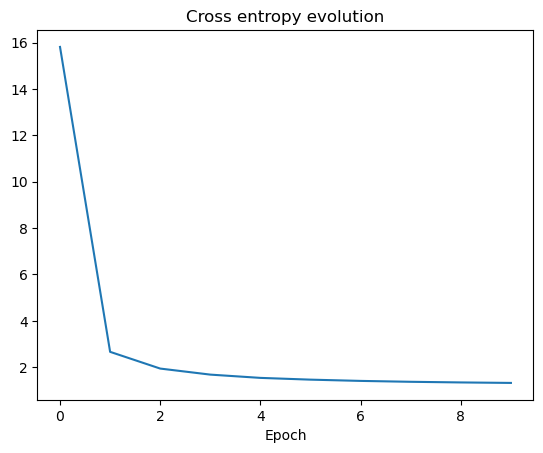

In [26]:
plt.plot(loss_evol)
plt.title("Cross entropy evolution")
plt.xlabel("Epoch")

## Test

In [27]:
model.eval()
loss_test = 0.
acc_test = 0.
with torch.no_grad():
    for data, target in test_loader:

        # Compute batch predictions
        output = model(data)
        # Compute loss
        loss = cross_entropy(output, target)

        # Accumulate batch losses
        loss_test += loss.item()

        # Accumulate correct predictions, highest score is predicted class.
        pred = output.argmax(dim=-1)
        acc_test += torch.sum(pred == target)

    print(f"Test loss: {loss_test/len(test_loader):.3f} \t Test acc: {acc_test*100/len(test_loader.dataset):.2f}")

Test loss: 1.292 	 Test acc: 51.83
